# Linear classifiers and the kernel trick

In [1]:
import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
import sklearn.datasets
from sklearn.model_selection import train_test_split

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [2]:
%matplotlib inline

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.family': 'serif', 
                     'font.serif':['Computer Modern']})

In [3]:
from numpy.fft import fft, ifft

def crvec(N, D=1):
    rphase = 2*np.pi * np.random.rand(int(D), int(N))
    return np.cos(rphase) + 1.0j * np.sin(rphase)

def scvec(N, D, K):
    letter_vectors_c = crvec(N, D)

    for d in range(D):
        ip = np.random.choice(int(N), size=int(N-K), replace=False)
        letter_vectors_c[d, ip] = 0
        
    return letter_vectors_c

def lccvec(N, D, Kv):
    # N needs to be multiple of Kv
    
    R = N/Kv
    
    assert(R==N//Kv)
    
    letter_vectors_c = 0*crvec(N, D)
    
    for d in range(D):
        ip = np.random.choice(int(R), size=int(Kv), replace=True)
        
        ip += int(R) * np.arange(int(Kv))
        
        letter_vectors_c[d, ip] = crvec(Kv, 1)
        
    return letter_vectors_c
    
def cconv(a, b, pa=1, pb=1):
    return ifft(fft(a)**pa * fft(b)**pb)
    
def ccinv(a):
    #return ifft(np.conj(fft(a)))
    return ifft(fft(a)**(-1))

def lccI(Nv, Kv):
    vv = 0.0*crvec(Nv, 1) 
    
    Rv = Nv//Kv
    
    vvr = np.reshape(vv, [int(Kv), int(Rv)])
    
    vvr[:, 0] = 1
    
    return vvr.flatten()    
    
    

def lccbind(vec1, vec2, Kv, pa=1, pb=1):
    Nv = vec1.shape[0]
    Rv = Nv/Kv

    vec1r = np.reshape(vec1, [int(Kv), int(Rv)])
    vec2r = np.reshape(vec2, [int(Kv), int(Rv)])

    vec_br = cconv(vec1r, vec2r, pa, pb)

    vec_b = vec_br.flatten()
    
    return vec_b

def lccperm(vec1, Kv, proll=1):
    Nv = vec1.shape[0]
    Rv = Nv/Kv

    vec1r = np.reshape(vec1, [int(Kv), int(Rv)])
    
    vec_perm = np.roll(vec1r, proll, axis=0)
    
    return vec_perm.flatten()

def lccinv(vec1, Kv):
    Nv = vec1.shape[0]
    Rv = Nv/Kv

    vec1r = np.reshape(vec1, [int(Kv), int(Rv)])
    
    vec1_ir = ccinv(vec1r)
    vec1_i = vec1_ir.flatten()
    
    return vec1_i

## Linear classification

We start by considering some toy datasets in two-dimensions. For instance, we will create a classification problem using samples drawn from "blobs" -- i.e. Gaussian distributed data with some center and variance.

For simple data like this, we can use linear separators to form classifiers. There are various ways to optimize the linear separators between classes, but fundamentally linear regresssion is the procedure that minimizes the error (based on euclidean distance) between the classifiers and the data. 

This is of course supervised learning, where we need some training data. We will then formulate the training data as one-hot vectors of the three classes to set-up the problem in a way we can solve with linear regression. 

In [5]:
n = 300 # number of data samples

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern


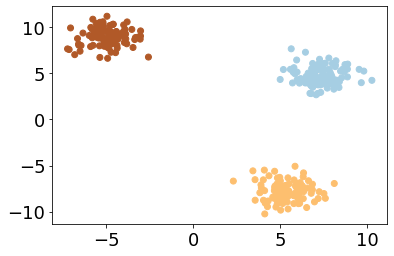

In [6]:
X, y = sklearn.datasets.make_blobs(n_samples=n, random_state=22786)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Paired)

In [7]:
y_hot = np.zeros((n, 3))

for i in range(n):
    y_hot[i, y[i]] = 1

Now we just form the least-squares estimate.

In [8]:
W_lstsq,resid,rank,sigma = np.linalg.lstsq(X,y_hot)


/var/folders/xn/hqbqng2d6nz8f1lcyd545kqr0000gn/T/ipykernel_6970/2325016662.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W_lstsq,resid,rank,sigma = np.linalg.lstsq(X,y_hot)


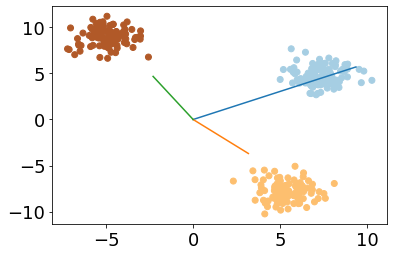

In [9]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Paired)

# I just scaled the vectors by 100 for better visualization
plt.plot([0,W_lstsq[0,0]*100], [0, W_lstsq[1,0]*100])
plt.plot([0,W_lstsq[0,1]*100], [0, W_lstsq[1,1]*100])
plt.plot([0,W_lstsq[0,2]*100], [0, W_lstsq[1,2]*100])


So the linear estimator finds vectors that point in the direction of the different classes. The higher the dot-product between the data-point and one of these vectors, then the more likely the data falls within the class. Then we can take the maximum amongst the three classes to make a decision about the data.

In [10]:
class_lstsq = np.argmax(np.dot(X, W_lstsq), axis=1)

In [11]:
x_samples = np.linspace(X[:,0].min(), X[:,0].max(), 100)
y_samples = np.linspace(X[:,1].min(), X[:,1].max(), 100)

kernel_image = np.zeros((len(x_samples), len(y_samples)))

for ix, xv in enumerate(x_samples):
    for iy, yv in enumerate(y_samples):
        cc = np.argmax(np.dot([xv,yv], W_lstsq))
        kernel_image[iy, ix] = cc
        
        

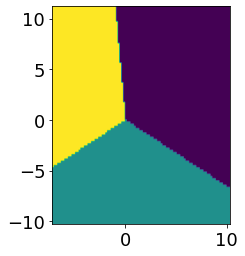

In [12]:
im_extent = [x_samples[0], x_samples[-1], y_samples[0], y_samples[-1]]
plt.imshow(kernel_image, extent=im_extent, origin='lower')


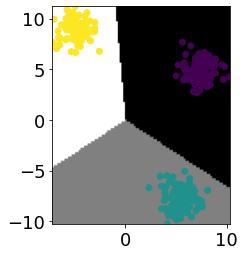

In [13]:
im_extent = [x_samples[0], x_samples[-1], y_samples[0], y_samples[-1]]
plt.imshow(kernel_image, extent=im_extent, origin='lower', cmap='gray')

plt.scatter(X[:,0], X[:,1], c=class_lstsq)

So above we have visualized the entire space of the data points. Any data within a given region will lead to the same classification. These regions also extend indefinitely.

We can also give the linear separators the ability to extend from a point other than the origin by adding an extra parameter for the offset. This can be encapsulated by adding an extra dimension to the data matrix where every entry is always 1.


In [14]:
Xb = np.ones((X.shape[0], X.shape[1]+1))
Xb[:,:-1] = X

Wb_lstsq,resid,rank,sigma = np.linalg.lstsq(Xb,y_hot)


/var/folders/xn/hqbqng2d6nz8f1lcyd545kqr0000gn/T/ipykernel_6970/163325755.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Wb_lstsq,resid,rank,sigma = np.linalg.lstsq(Xb,y_hot)


In [15]:
x_samples = np.linspace(X[:,0].min(), X[:,0].max(), 100)
y_samples = np.linspace(X[:,1].min(), X[:,1].max(), 100)

kernel_image = np.zeros((len(x_samples), len(y_samples)))

for ix, xv in enumerate(x_samples):
    for iy, yv in enumerate(y_samples):
        cc = np.argmax(np.dot([xv,yv, 1], Wb_lstsq))
        kernel_image[iy, ix] = cc
        
        

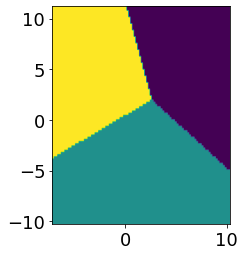

In [16]:
im_extent = [x_samples[0], x_samples[-1], y_samples[0], y_samples[-1]]
plt.imshow(kernel_image, extent=im_extent, origin='lower')


In [17]:
Wb_lstsq

array([[ 0.09742393, -0.02337258, -0.07405136],
       [ 0.05957096, -0.07294565,  0.01337469],
       [-0.0379745 ,  0.53883943,  0.49913507]])

## The kernel trick: turning distance into dot product


One reason that conventional machine learning started with toy datasets like this, was because most of machine learning culture came from statistics and mathematics in the 80s and 90s. In this world, Gaussian distributions were extremely well understood and classification problems could be well formulated and objectively optimized -- which mathematicians love!

Then there is a simple intuition when faced with a classification of this formulation. Since the likelihood of a sample is related to the distance to the mean of the distribution, then using the distance between samples as a metric for classification would seem to be a good idea. 

Another thing mathematicians love are dot-products. In vector spaces, the dot-product is a very natural and common computation. Generally, when we use vector representations and feature spaces, we are relying on the notion of features being similar based on the dot-product of the feature vectors. 

However, dot-products are linear operations. Many datasets, however, are not linearly separable, which means that the classes cannot be divided using a line (or plane or hyper-plane in higher dimensions). 

So then for advancing data classification, mathematicians developed the "kernel trick". This is a procedure to project the data into a higher dimensional space, based on higher-order features of the data. In this higher dimensional space, data classes can become separable by a linear classifier -- assuming that you can find good higher order features. 

Here, we see that the data is linearly separable, and so the linear classifier does a good job. Next, we will also go through the procedure of the kernel trick to demonstrate the idea. 

However, there is generally a well-known computational issue with the kernel trick. The complexity grows quadratically with the number of data samples, which can become an issue. An important idea in the literature was put forward by Rahimi and Recht, 2007, which explains how kernels based on radial basis functions can be approximated.

https://proceedings.neurips.cc/paper_files/paper/2007/file/013a006f03dbc5392effeb8f18fda755-Paper.pdf

In this case we are going to rely on the special properties of high-dimensional random vectors to approximate the kernel. In many cases, this can be much more computational or memory efficient.

We will start by first forming the Random Fourier Features of Rahimi and Rect. See also:
https://en.wikipedia.org/wiki/Radial_basis_function_kernel


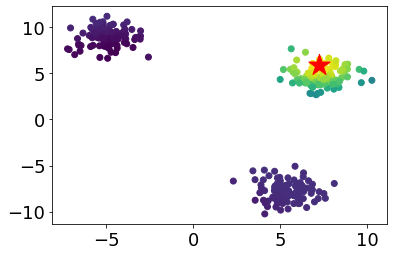

In [75]:
d = 500 # dimensionality
sigma = 0.4 # size of the kernel 
sidx = 22 # index of sample to visualize

# Create the random fourier features
Phi = np.random.normal(0, sigma, size=(d,X.shape[1]))
b = np.random.uniform(0, 2*np.pi, size=(1,d))
# you can just use cosine wave
#Z = np.sqrt(2/d)*np.cos(Phi.dot(X.T).T + b) 
# but on closer inspection of Rahimi and Recht, 2007, they actually do use the complex definition. 
# they just concatenate the cosine and sine waves
Z = np.sqrt(1/d) * np.hstack((np.cos(Phi[:(d//2), :].dot(X.T).T + b[0, :(d//2)][None]), 
                             np.sin(Phi[:(d//2), :].dot(X.T).T + b[0, :(d//2)][None])))
# however, in their formulation they just concatenate the real and imag terms, but this is
# exactly like complex numbers. 

similarities = Z.dot(Z[sidx,:])

plt.scatter(X[:,0], X[:,1], c=similarities)
plt.scatter(X[sidx,0], X[sidx,1], c="red", marker="*", s=500)

What we are visualizing in the figure above is the similarity between the random fourier features defined by each sample in the data set. Samples that are colored yellow/brighter are more similar to the target sample than the other samples in the data set. 

So if we wanted to build a one-shot classifier, we could just compare the similarity of the learned sample to the new samples coming in. If the similarity is above threshold, then we would consider it as part of the same class.

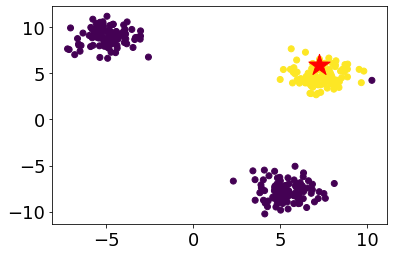

In [76]:
sim_thresh = 0.2

same_class = similarities > sim_thresh

plt.scatter(X[:,0], X[:,1], c=same_class)
plt.scatter(X[sidx,0], X[sidx,1], c="red", marker="*", s=500)

The yellow samples would all then be considered in the same class as the initial sample. 

The random fourier features form a kernel space. The shape of the kernel is determined by the Bochner theorm. In essence, the probability distribution of the random features determines the exact shape of the kernel. The shape is computed through a Fourier transform, where in this example we used a Gaussian distribution of samples, which produces in the Fourier domain also a Gaussian distribution. So the kernel is the shape of a two-dimensional Guassian.

So lets try and visualize this. First, I'm just going to plot the similarities between the samples as a function of distance.

<BarContainer object of 300 artists>

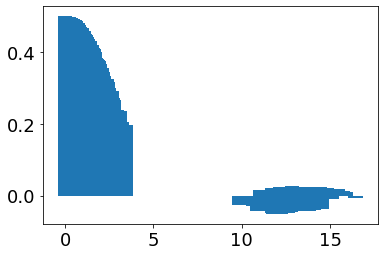

In [77]:
distances = ((X[sidx,0]-X[:,0])**2 + (X[sidx,1]-X[:,1])**2)**0.5

plt.bar(distances, similarities)

So then we can start to see the shape of the kernel as sampled from the data. 

Another way is to just brute-force our way through the entire space and sample the kernel.

In [78]:
x_samples = np.linspace(X[:,0].min(), X[:,0].max(), 100)
y_samples = np.linspace(X[:,1].min(), X[:,1].max(), 100)

kernel_image = np.zeros((len(x_samples), len(y_samples)))

for ix, xv in enumerate(x_samples):
    for iy, yv in enumerate(y_samples):
        s_rff = np.sqrt(2/d)*np.cos(Phi.dot([yv,xv]).T + b)
        kernel_image[ix, iy] = s_rff.dot(Z[sidx, :])
        
        

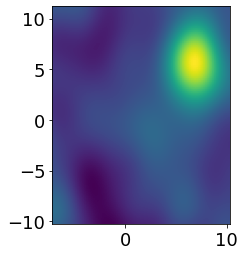

In [79]:
im_extent = [x_samples[0], x_samples[-1], y_samples[0], y_samples[-1]]
plt.imshow(kernel_image, extent=im_extent, origin='lower')


This is the two-dimensional Gaussian blob that defines the kernel. This kernel is translation invariant, and depending on the sample we chose it could appear in different locations. 

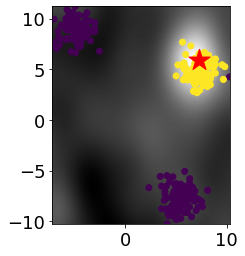

In [80]:
im_extent = [x_samples[0], x_samples[-1], y_samples[0], y_samples[-1]]
plt.imshow(kernel_image, extent=im_extent, origin='lower', cmap='gray')

plt.scatter(X[:,0], X[:,1], c=same_class)
plt.scatter(X[sidx,0], X[sidx,1], c="red", marker="*", s=500)

If we superpose the data on top of the kernel map we can get a clear sense of how the classification system works. The threshold defines a radius around the center of the kernel for which data samples would be in or out of class. 

## How similar are VFA and RFF?

Now, the way we do this with what we call Vector Function Architectures is extremely close mathematically. 



In [81]:
# Create some random phasor vectors (uniform samples)
vX = crvec(d)[0]
vY = crvec(d)[0]

In [82]:
beta = 0.2
data_vecs = 0.0*crvec(d, X.shape[0])

for i in range(X.shape[0]):
    data_vecs[i] = vX ** (beta*X[i,0]) * vY ** (beta*X[i,1])
    
vfa_sims = np.real(data_vecs.dot(np.conj(data_vecs[sidx,:])))/d

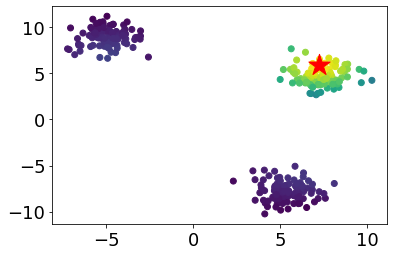

In [83]:
plt.scatter(X[:,0], X[:,1], c=vfa_sims)
plt.scatter(X[sidx,0], X[sidx,1], c="red", marker="*", s=500)

So, what we did here we like to call the "exponentiation trick". We have started by drawing random VFA vectors vX and vY, which are vectors of unit magnitude complex numbers. The phases are distributed uniformly. Then we exponentiate the vectors proportional to the coordinates of the data samples. We can use the binding operation to create a code for each dimension. There is then a parameter that also determines the scale of the kernel, beta.

As you can see, the result looks very familiar. And if we dive into the mathematics we can clearly see why. 

Basically, lets start by just noting that it is somewhat of a trivial step to link the cosine wave as described in Rahimi and Rect into a complex-valued wave. 

In [84]:
Phi = np.random.normal(0, sigma, size=(d,X.shape[1]))
b = np.random.uniform(0, 2*np.pi, size=(1,d))

# Can do RFF with the complex numbers
Zc = np.cos(Phi.dot(X.T).T+b) + 1.0j * np.sin(Phi.dot(X.T).T+b)
crff_sims = np.real(Zc.dot(np.conj(Zc[sidx,:])))/d

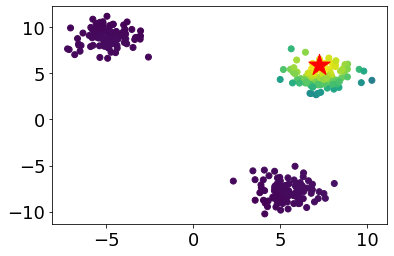

In [85]:
# still has a similar kernel property
plt.scatter(X[:,0], X[:,1], c=crff_sims)
plt.scatter(X[sidx,0], X[sidx,1], c="red", marker="*", s=500)

Converting to complex space doesn't really change the situation much. 

(The dimensionality of the vector is perhaps larger, since there are now two complex values per entry. But since there is a free parameter that defines the dimensionality this is not really anything signficant.)

So we see that RFF could be written in complex form
$$
z_i = cos(\Phi_{i,x} x + \Phi_{i,y} y + b_i) + \textrm{i} sin(\Phi_{i,x} x + \Phi_{i,y} y + b_i)
$$

and the values $\Phi_{i,x} \sim \mathcal{N}(0, \sigma)$ are random gaussian values.

So, then we can rewrite this:
$$
z_i = e^{\textrm{i} (\Phi_{i,x} x +\Phi_{i,y} y + b_i)} = e^{\textrm{i} \Phi_{i,x} x} e^{\textrm{i} \Phi_{i,y} y} e^{\textrm{i} b_i} 
$$

So then here is exactly VFA. When adjusted to complex space, the formulation of Rahimi and Rect is exactly the exponentiation trick in VFA. 

The only difference left is that what VFA started with was the random vales of $\Phi$ are uniform rather than Gaussian. But as we describe in the VFA paper, it is the probability distribution of these random features that define the shape of the kernel. Gaussian distributions give Gaussian kernels, Uniform distributions give a kernel in the shape of the sinc function. 


The extra $e^{\textrm{i} b_i}$ factor doesn't really do much. I like to think of this as a simple change in reference frame from the VFA perspective.  

In [86]:
x_samples = np.linspace(X[:,0].min(), X[:,0].max(), 100)

kernel_1d = np.zeros(len(x_samples))

center_vec = vX ** (beta * X[sidx,0]) * vY ** (beta * X[sidx,1])

for ix, xv in enumerate(x_samples):
    vv = vX ** (beta * xv) * vY ** (beta * X[sidx,1])
    kernel_1d[ix] = np.real(np.dot(np.conj(center_vec), vv)) / d
    

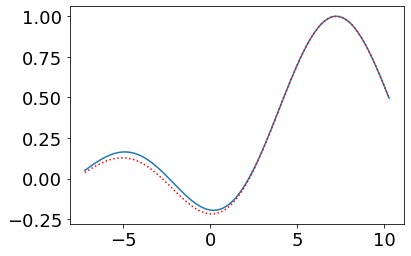

In [87]:
plt.plot(x_samples, kernel_1d)
# The kernel is the sinc function!
plt.plot(x_samples, np.sinc(beta*(x_samples - X[sidx,0])), ':r')

So you can see that the shape of the kernel is in fact the sinc function, which is a very special and important function in signal processing. This is simply what happens when the sample distribution is uniform rather than Gaussian. 

We can visualize the full two-dimensional sinc function as well.

In [88]:
x_samples = np.linspace(X[:,0].min(), X[:,0].max(), 100)
y_samples = np.linspace(X[:,1].min(), X[:,1].max(), 100)

kernel_image = np.zeros((len(x_samples), len(y_samples)))

for ix, xv in enumerate(x_samples):
    for iy, yv in enumerate(y_samples):
        
        vv = vX ** (beta * xv) * vY ** (beta * yv)
        
        kernel_image[iy, ix] = np.real(np.dot(np.conj(center_vec), vv)) / d    

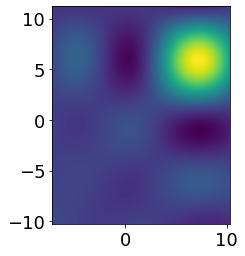

In [89]:
im_extent = [x_samples[0], x_samples[-1], y_samples[0], y_samples[-1]]
plt.imshow(kernel_image, extent=im_extent, origin='lower')


Even though this is the sinc kernel, it still has a pretty decent ability to be used as part of a simple one-shot classifier.

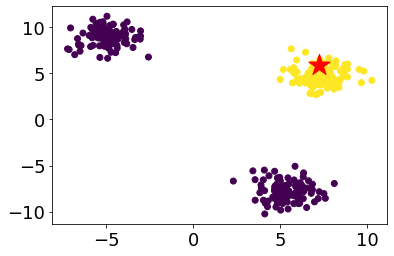

In [90]:
sim_thresh = 0.2

vfa_same = vfa_sims > sim_thresh

plt.scatter(X[:,0], X[:,1], c=vfa_same)
plt.scatter(X[sidx,0], X[sidx,1], c="red", marker="*", s=500)

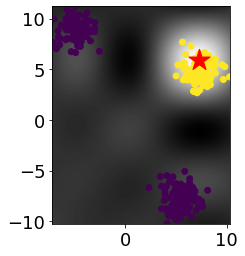

In [91]:
im_extent = [x_samples[0], x_samples[-1], y_samples[0], y_samples[-1]]
plt.imshow(kernel_image, extent=im_extent, origin='lower', cmap='gray')

plt.scatter(X[:,0], X[:,1], c=vfa_same)
plt.scatter(X[sidx,0], X[sidx,1], c="red", marker="*", s=500)

Of course, again we have a free parameter beta that determines the scale of the sinc function/kernel. By hand tuning this scale, we have performed feature engineering.

## Continual Learning?

Lets try to do some continual learning.

We will formulate a simple algorithm. If a new data point comes in and is close to one of the classifiers, then we add that data to the class. If there are no matches, we will just allocate a new neuron and a new class.



In [92]:
class_thresh = 0.25

max_classes = 10
classifier_W = 0.0 * crvec(max_classes, d).T

next_new_class = 0
class_plasticity = np.zeros(max_classes)

sims_hist = np.zeros((X.shape[0], max_classes))

for ix in range(200):
    xv = X[ix, 0]
    yv = X[ix, 1]
    
    vv = vX ** (beta * xv) * vY ** (beta * yv)
    
    sims = np.real(classifier_W @ np.conj(vv)) / d
    
    sims_hist[ix, :] = sims
    
    if np.all(sims < class_thresh):
        print(ix, xv, yv, ": new class")
        classifier_W[next_new_class, :] += vv
        class_plasticity[next_new_class] += 1
        
        next_new_class += 1 
        if next_new_class >= max_classes:
            print("max class exceeded")
            next_new_class = 0
        
    else:
        win_idx = np.argmax(sims)
        print(ix, xv, yv,": update class", win_idx)
        
        classifier_W[win_idx, :] = (vv + class_plasticity[win_idx] * classifier_W[win_idx, :]) \
                            / (class_plasticity[win_idx]+1)
        
        class_plasticity[win_idx] += 1
    
    

0 -5.764894737303341 10.886201315179145 : new class
1 -3.042537062140443 8.721273861063748 : update class 0
2 -4.930615562342518 9.488514135323262 : update class 0
3 8.174394408668864 5.926392397742341 : new class
4 7.141873609906648 5.3791767640389985 : update class 1
5 7.110493306121051 4.2495430811135275 : update class 1
6 -4.412990401697481 9.550136155889136 : update class 0
7 -3.991750185125256 10.26435638537659 : update class 0
8 -5.969819164423003 9.118270228347109 : update class 0
9 6.8659657343586336 6.082993866005502 : update class 1
10 6.441639310924826 3.9666793447188073 : update class 1
11 5.85497917977676 -5.076678846373792 : new class
12 4.714796613922022 -7.481361772155762 : update class 2
13 2.3090880758078565 -6.684072854104022 : update class 2
14 8.881220868553038 6.014287277412546 : update class 1
15 5.191690866057043 -8.05118421485339 : update class 2
16 -3.942312168279632 9.069450758295584 : update class 0
17 -5.803040201876281 8.872638596223503 : update class 0
1

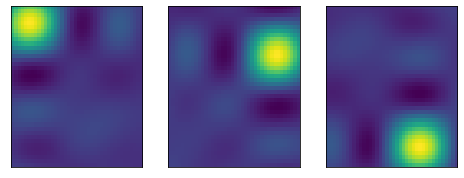

In [93]:
x_samples = np.linspace(X[:,0].min(), X[:,0].max(), 40)
y_samples = np.linspace(X[:,1].min(), X[:,1].max(), 40)

kernel_image = np.zeros((len(x_samples), len(y_samples)))

im_extent = [x_samples[0], x_samples[-1], y_samples[0], y_samples[-1]]
    
plt.figure(figsize=(8,3))

show_weights = [0, 1, 2]
#show_weights = [0, 1, 2, 3, 4, 5, 6, 7]
for c in range(len(show_weights)):
    class_result = classifier_W[show_weights[c],:]
    plt.subplot(1,len(show_weights),c+1)
    
    for ix, xv in enumerate(x_samples):
        for iy, yv in enumerate(y_samples):

            vv = vX ** (beta * xv) * vY ** (beta * yv)

            kernel_image[iy, ix] = np.real(np.dot(np.conj(class_result), vv)) / d    
    
    plt.imshow(kernel_image, extent=im_extent, origin='lower')
    plt.xticks([])
    plt.yticks([])

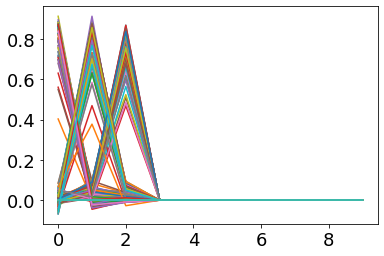

In [94]:
plt.plot(sims_hist[:,:].T);

This algorithm, however, has all sorts of issues. First, it is very sensitive to the correct bandwidth parameter for the classifier. If the bandwidth parameter is too small then points in the same class will be allocated to new classes. Second, it also depends on the assumption that the classes are gaussian distributed, and would have a hard time with other types of data distributions. 



## VFA encoding with sparse block codes

In the VFA paper, we explain how then the Bochner theorm determines the kernel shape, and that you can create a lot of different types of kernel shapes that might be relevant. Some notable examples, if the probability distribution of the phases are discrete, then you can create a kernel that also has a circular topology, as well, by sampling from a discrete two-dimensional distribution, one can create kernel shapes like a hexagonal grid that resembles grid cells in neuroscience. 

But what's important for this thread is the connection between the VSAs that can be utilized to extend VFA. From our capacity paper, and ultimately stemming from the law of large numbers, the random distributions that different flavors of VSAs utilize do not change much the properties of the encoding. 

If we can connect then VFA to other flavors of VSA, then we could take advantage of the alternative implementations for gains in efficiency on hardware, especially if we can utilize sparse and discrete representations. 

So then can we extend VFA and the idea of the exponentiation trick/fractional binding to other flavors of VSA? 

In [95]:
## lets do something similar with sparse block code

N = d
K = 50

# codevectors for the two dimensions
vX = lccvec(N, 1, K)[0]
vY = lccvec(N, 1, K)[0]

beta = 0.3

sdata_vecs = 0.0*crvec(N, X.shape[0])

for i in range(X.shape[0]):
    sdata_vecs[i] = lccbind(vX, vY, K, beta*X[i,0], beta*X[i,1])

svfa_sims = np.real(sdata_vecs.dot(np.conj(sdata_vecs[sidx,:])))/d

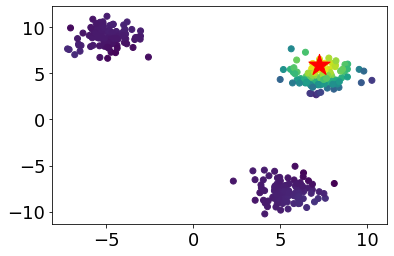

In [96]:

plt.scatter(X[:,0], X[:,1], c=svfa_sims)
plt.scatter(X[sidx,0], X[sidx,1], c="red", marker="*", s=500)

In [97]:
x_samples = np.linspace(X[:,0].min(), X[:,0].max(), 100)
y_samples = np.linspace(X[:,1].min(), X[:,1].max(), 100)

kernel_image = np.zeros((len(x_samples), len(y_samples)))

for ix, xv in enumerate(x_samples):
    for iy, yv in enumerate(y_samples):
        
        vv = lccbind(vX, vY, K, beta*xv, beta*yv)
        
        kernel_image[iy, ix] = np.real(np.dot(np.conj(sdata_vecs[sidx,:]), vv)) / d    

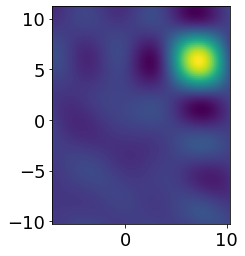

In [98]:
im_extent = [x_samples[0], x_samples[-1], y_samples[0], y_samples[-1]]
plt.imshow(kernel_image, extent=im_extent, origin='lower')


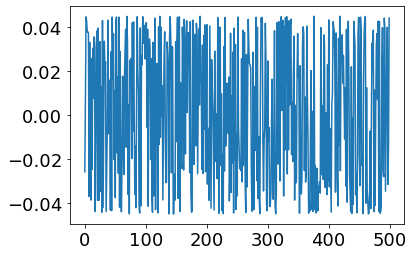

In [99]:
# So if we look at the values of the random fourier features, they are very dense
plt.plot(Z[0]) # feature vector for one sample

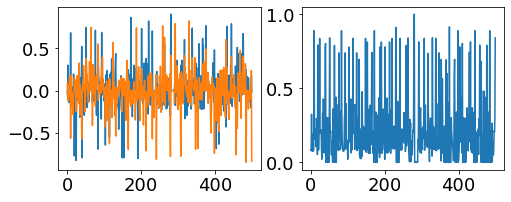

In [100]:
# But of course the feature vectors for the block code are K sparse -ish
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(sdata_vecs[0].real)
plt.plot(sdata_vecs[0].imag)
plt.subplot(122)
plt.plot(np.abs(sdata_vecs[0]))

What we can see is that by translating the exponentiation trick into a different VSA flavor, we can still get the same kernel effects. 

We can see that the sparse phasor block code used here works, but the vectors are close to sparse, but not perfect. How does the performance interact with discretization? Can we design and optimize a more ideal randomized representation for Loihi 2? 
